# Metric Calculation
Calculate metrics for models run on the full dataset

## Imports and Data Loading

In [180]:
import xgboost
from xgboost import plot_importance
from bgpredict.helpers import S3Connection
from dotenv import load_dotenv
import multiprocessing
import json
import os
import numpy as np
from numpy.random import default_rng
import pandas as pd
from dotenv import load_dotenv
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
import sqlalchemy
from sqlalchemy import create_engine
from datetime import datetime
from skopt import BayesSearchCV, dump, load
from skopt.plots import plot_objective, plot_histogram
import s3fs
import matplotlib.pyplot as plt 
import torch
from torch import nn

In [96]:
os.chdir('../')
load_dotenv()
os.chdir('./Notebooks')

In [181]:
def clean_data(df, drop_cols = ["timestamp", "date", "time"]):
    # Drop rows with no Y value
    df = df.dropna(subset='bg')

    # Fill nulls (lag BG values) with 0 to indicate data is unavailable
    print(f"Null values to be filled by column:")
    nulls = df.isna().sum()
    null_idx = list(nulls.index)
    vals = list(nulls)
    for col, val in list(zip(null_idx, vals)):
        if val > 0:
            print(col, val)
    df = df.fillna(0)

    # Sort by timestamp
    current_len = len(df)
    df = df.loc[~(df['timestamp_clean'].apply(type) == int), :]
    print(f"Dropping {current_len - len(df)} invalid timestamps")
    df = df.sort_values(by="timestamp_clean")

    # Set index to time_stamp_clean
    df.index = df['timestamp_clean']
    df = df.drop(labels=['timestamp_clean'], axis=1)

    # Drop first row by subject which has data quality issues
    df = df[df.groupby('subjectid').cumcount() > 0]

    # Drop columns that are indices, irrelevant, or capture in OHE variables
#     drop_cols = ['timestamp', 'date', 'time']
    df = df.drop(labels=drop_cols, axis=1)

    # One hot Encode Weekdays
    weekdays = np.unique(df['weekday'])
    ohe_weekdays = [f"ohe_{day}" for day in weekdays]
    df[ohe_weekdays] = pd.get_dummies(df.weekday)
    df = df.drop(labels="weekday", axis=1)

    return df

In [187]:
location = f"postgresql://postgres:{os.environ.get('db_password')}@{os.environ.get('db_location')}"
engine = create_engine(location)
conn = engine.connect()
raw_df = pd.read_sql("select * from public.tb_final_dataset where test_set = 1", conn)
clean_df = clean_data(raw_df)

Null values to be filled by column:
bg_lag_1 6593
bg_lag_2 6449
bg_lag_3 6420
bg_lag_4 6548
bg_lag_5 6614
bg_lag_6 6577
bg_lag_7 6653
bg_lag_8 6720
bg_lag_9 6683
bg_lag_10 6694
bg_lag_11 6746
bg_lag_12 6758
Dropping 0 invalid timestamps


In [188]:
s3_conn = S3Connection()

## Helper Funcs

In [26]:
def graph_metrics(model_type, overall_metrics, by_subject_metrics, text_y):
    fig, axs = plt.subplots(1,3, sharey=True, figsize=(15,3))
    for idx, key in enumerate(by_subject_metrics):
        ax = axs[idx]
        ax.hist(by_subject_metrics[key], bins=100)
        ax.set_title(f"{key.upper()}")
        overall_metric = overall_metrics[key]
        vertical_line = ax.axvline(overall_metric, color='red', label=f'Test {key.upper()}')
        ax.text(x = overall_metric+ 0.01 * ax.get_xlim()[1], y=text_y, s=np.round(overall_metric, 2))
        x_coord = vertical_line.get_xdata()[1]
        ax.legend()
        ax.set_xlabel(f"{key.upper()}")
        plt.suptitle(f'{model_type} Evaluation Metrics by Subject', y=1.15, fontsize=15)
        plt.title('Root Mean Square Error (RMSE), Mean Absolute Error (MAE), and Mean Absolute Prediction Error (MAPE)',
                  x=0.5, transform=fig.transFigure, fontsize=12)
        fig.supylabel("Subject Count", x=0.08)

## Arima

In [63]:
arima_locs = s3_conn.s3_client.list_objects_v2(Bucket=s3_conn.bucket_name, Prefix="models/arima/")
arima_locs['Contents']
result_uris = []
for x in arima_locs["Contents"]:
    path = x['Key']
    if "results" in path:
        uri = f"s3://{s3_conn.bucket_name}/{path}"
        result_uris.append(uri)
result_dfs= []
for uri in result_uris:
    df = pd.read_csv(uri)
    df.columns = ['subjectid', 'entryid', 'y', 'y_hat']
    result_dfs.append(df)
result_dfs[0].head()

,subjectid,entryid,y,y_hat
0,12689381,575,154.0,145.398916
1,12689381,574,147.0,147.389779
2,12689381,573,140.0,148.096161
3,12689381,572,134.0,147.715828
4,12689381,571,130.0,146.491036


In [64]:
arima_df = pd.concat(result_dfs)

# There are 162 rows where y == 0 which artificially inflates MAPE
arima_df = arima_df.loc[arima_df['y'] != 0,:]
print(arima_df.shape)

(1253986, 4)


In [65]:
test = arima_df.loc[arima_df['y_hat'] > 1000, :]
erroneous_subject =np.unique(test['subjectid'])[0]
print(erroneous_subject)
test.describe()

93839818


,subjectid,entryid,y,y_hat
count,13508.0,13508.000000,13508.000000,13508.000000
mean,93839818.0,201722.300933,120.995114,1932.249169
std,0.0,8532.815657,54.468599,538.248621
min,93839818.0,187136.000000,38.000000,1000.078731
25%,93839818.0,194159.500000,83.000000,1466.163950
50%,93839818.0,202201.000000,110.000000,1932.249169
75%,93839818.0,209226.500000,147.000000,2398.334388
max,93839818.0,216135.000000,400.000000,2864.419607


Subject 93839818's predictions are erroneous. Drop this subject when evaluating ARIMA metrics.

In [66]:
arima_df = arima_df.loc[arima_df['subjectid'] != erroneous_subject]

In [67]:
full_mse = mean_squared_error(arima_df['y'], arima_df['y_hat'])
full_rmse = np.sqrt(full_mse)
full_mae = mean_absolute_error(arima_df['y'], arima_df['y_hat'])
full_mape = mean_absolute_percentage_error(arima_df['y'], arima_df['y_hat'])
print(f'MSE: {full_mse}')
print(f'RMSE: {full_rmse}')
print(f'MAE: {full_mae}')
print(f'MAPE: {full_mape}')
full_metrics = {'rmse':full_rmse, "mae": full_mae, "mape": full_mape}

MSE: 8117.6496236625935
RMSE: 90.09800010911782
MAE: 57.78072210054919
MAPE: 0.5339585423736942


In [68]:
metrics = {'rmse':[], "mae": [], "mape": []}
grouped = arima_df.groupby('subjectid')
for name, group in grouped:
    mse = mean_squared_error(group['y'], group['y_hat'])
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(group['y'], group['y_hat'])
    mape = mean_absolute_percentage_error(group['y'], group['y_hat'])
    metrics['rmse'].append(rmse)
    metrics['mae'].append(mae)
    metrics['mape'].append(mape)

In [69]:
def graph_metrics(model_type, overall_metrics, by_subject_metrics, text_y):
    fig, axs = plt.subplots(1,3, sharey=True, figsize=(15,3))
    for idx, key in enumerate(by_subject_metrics):
        ax = axs[idx]
        ax.hist(by_subject_metrics[key], bins=100)
        ax.set_title(f"{key.upper()}")
        overall_metric = overall_metrics[key]
        vertical_line = ax.axvline(overall_metric, color='red', label=f'Test {key.upper()}')
        ax.text(x = overall_metric+ 0.01 * ax.get_xlim()[1], y=text_y, s=np.round(overall_metric, 2))
        x_coord = vertical_line.get_xdata()[1]
        ax.legend()
        ax.set_xlabel(f"{key.upper()}")
    _ = plt.suptitle('ARIMA Evaluation Metrics by Subject', y=1.15, fontsize=15)
    _ = plt.title('Root Mean Square Error (RMSE), Mean Absolute Error (MAE), and Mean Absolute Prediction Error (MAPE)',
                  x=0.5, transform=fig.transFigure, fontsize=12)
    _ = fig.supylabel("Subject Count", x=0.08)

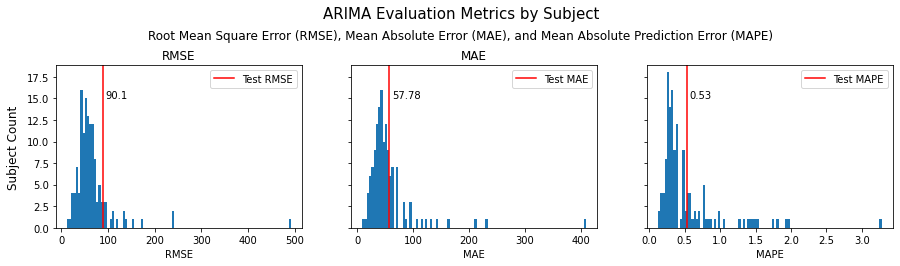

In [71]:
graph_metrics("ARIMA", full_metrics, metrics, 15)

(-100.0, 600.0)

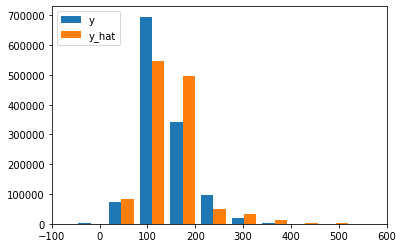

In [17]:
# _ = plt.hist(arima_df['y_hat'], bins=20, color='red')
_ = plt.hist([arima_df['y'], arima_df['y_hat']], bins=20, label = ['y', 'y_hat'])
plt.legend(loc="upper left")
plt.xlim(-100, 600)

## XGBoost

### XGBoost Load

In [182]:
# model_loc =  "models/xgboost/02.11.36.475845_L4607592"
model_loc = 'models/xgboost/11.21.42.393804_L4169251'

In [185]:
fs = s3fs.S3FileSystem()
bst = xgboost.XGBRegressor()

path = "./model.json"
with fs.open(f"bgpredict/{model_loc}", 'rb') as f:
    bst.load_model(bytearray(f.read()))

### XGBoost Feature Importance

In [14]:
gain = bst.get_booster().get_score(importance_type='gain')
covers = bst.get_booster().get_score(importance_type='cover')
freq = bst.get_booster().get_score(importance_type='weight')

In [13]:
importances = list(zip(bst.feature_names_in_, bst.feature_importances_))
weekday = 0
subjectid = 0 
other = []
for x in importances:
    if 'ohe' in x[0]:
        indicator = x[0].split("_")[1]
        try:
            int(indicator)
            subjectid += x[1]
        except:
            weekday += x[1]
    else:
        key = x[0]
        if key == "normalized_carbs_datapercentile":
            k = "Carb Data Rank"
        elif key == "normalized_insulin_datapercentile":
            k = "Insulin Data Rank"
        elif key == "carbs_datacount":
            k = "Recorded Carb Count"
        elif key == "insulin_datacount":
            k = "Recorded Insulin Count"
        elif key == "datediff_currentbg_lastbg_inseconds":
            k = "Time Since Last BG"
        else:
            k = key.replace("_", " ")
        
        other.append((k, x[1]))
other.append(("Weekday Effects", weekday))
other.append(("Subject ID", subjectid))
other.sort(key=lambda x: x[1])
# other

Text(0.5, 1.0, 'XGBoost Feature Importance')

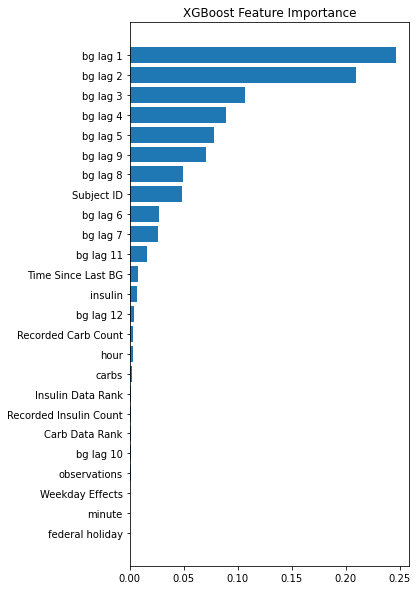

In [14]:
fig, ax = plt.subplots(figsize=(5, 10))
ax.barh(y=[x[0] for x in other], width=[x[1] for x in other])
plt.title("XGBoost Feature Importance")

### XGBoost Metrics

In [189]:
drop_cols = ['train_set', 'validation_set', 'test_set', 'subjectid', 'entryid', 'bg']
pred_df = clean_df.drop(drop_cols, axis=1)
preds = bst.predict(pred_df)

In [18]:
clean_df.loc[: , ['subjectid', 'entryid', 'bg']].reset_index()

,timestamp_clean,subjectid,entryid,bg
0,2016-08-10 00:43:50.664,68267781,43948,196.0
1,2016-08-10 00:48:51.032,68267781,43947,197.0
2,2016-08-10 01:13:49.950,68267781,43942,184.0
3,2016-08-10 01:23:49.686,68267781,43940,179.0
4,2016-08-10 01:33:50.462,68267781,43938,162.0
...,...,...,...,...
1305550,2021-03-18 23:36:58.983,56958831,29697,132.0
1305551,2021-03-18 23:41:59.650,56958831,29696,129.0
1305552,2021-03-18 23:46:58.908,56958831,29695,122.0
1305553,2021-03-18 23:51:59.718,56958831,29694,120.0


In [190]:
# rng = default_rng(46)
# subjects = clean_df.groupby("subjectid")['entryid'].count().sort_values()
# subjects = list(subjects.loc[subjects > 1000].index)
# drop_subjects = rng.choice(subjects, 14)
# drop_subjects
held_out_subjects = [60844515, 41131654, 40997757, 94200862, 91161972, 28608066,
       76817975, 37875431, 63047517, 72492570, 80796147, 87770486,
       95851255, 70454270]

In [191]:
y_hat = pd.Series(preds, name='y_hat')
dfs = [clean_df.loc[:, ['subjectid', 'entryid', 'bg']].reset_index(drop=True), y_hat]
xgboost_df = pd.concat(dfs, axis=1, ignore_index=True)
xgboost_df.columns = ["subjectid", "entryid", "y", "y_hat"]
# Drop 162 0 values which artificially inflate MAPE 
xgboost_df = xgboost_df.loc[ xgboost_df['y'] !=0, :]
xgboost_df.head()

,subjectid,entryid,y,y_hat
0,68267781,43948,196.0,195.525818
1,68267781,43947,197.0,200.001999
2,68267781,43942,184.0,195.169403
3,68267781,43940,179.0,184.083710
4,68267781,43938,162.0,174.461395


In [21]:
hold_out_df = xgboost_df.loc[xgboost_df.subjectid.isin(held_out_subjects), :]
in_sample_df = xgboost_df.loc[~xgboost_df.subjectid.isin(held_out_subjects), :]

In [22]:
full_mse = mean_squared_error(in_sample_df['y'], in_sample_df['y_hat'])
full_rmse = np.sqrt(full_mse)
full_mae = mean_absolute_error(in_sample_df['y'], in_sample_df['y_hat'])
full_mape = mean_absolute_percentage_error(in_sample_df['y'], in_sample_df['y_hat'])
print(f'MSE: {full_mse}')
print(f'RMSE: {full_rmse}')
print(f'MAE: {full_mae}')
print(f'MAPE: {full_mape}')
full_metrics = {'rmse':full_rmse, "mae": full_mae, "mape": full_mape}

MSE: 155.81821034978262
RMSE: 12.482716465168254
MAE: 6.063082698130701
MAPE: 0.06385485558665073


In [23]:
full_mse = mean_squared_error(hold_out_df['y'], hold_out_df['y_hat'])
full_rmse = np.sqrt(full_mse)
full_mae = mean_absolute_error(hold_out_df['y'], hold_out_df['y_hat'])
full_mape = mean_absolute_percentage_error(hold_out_df['y'], hold_out_df['y_hat'])
print(f'MSE: {full_mse}')
print(f'RMSE: {full_rmse}')
print(f'MAE: {full_mae}')
print(f'MAPE: {full_mape}')
full_metrics = {'rmse':full_rmse, "mae": full_mae, "mape": full_mape}

MSE: 179.64949186231453
RMSE: 13.403338832631015
MAE: 6.0331813809360755
MAPE: 0.06675165869624046


In [24]:
metrics = {'rmse':[], "mae": [], "mape": []}
grouped = xgboost_df.groupby('subjectid')
for name, group in grouped:
    mse = mean_squared_error(group['y'], group['y_hat'])
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(group['y'], group['y_hat'])
    mape = mean_absolute_percentage_error(group['y'], group['y_hat'])
    if mape >1000:
        print(group['subjectid'].iloc[0])
    metrics['rmse'].append(rmse)
    metrics['mae'].append(mae)
    metrics['mape'].append(mape)

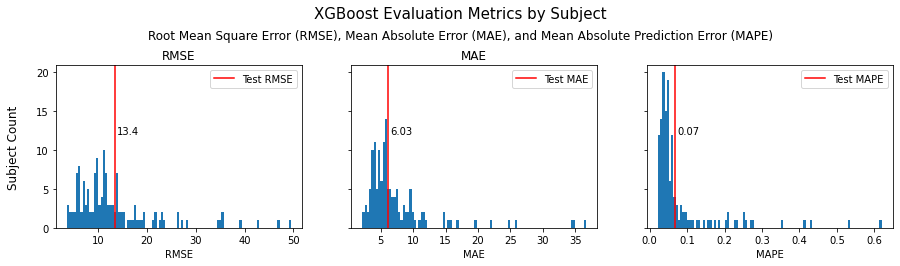

In [62]:
graph_metrics("XGBoost", full_metrics, metrics, 12)

In [40]:
test = []
for name, group in grouped:
    mse = mean_squared_error(group['y'], group['y_hat'])
    rmse = np.sqrt(mse)
#     mae = mean_absolute_error(group['y'], group['y_hat'])
#     mape = mean_absolute_percentage_error(group['y'], group['y_hat'])
    std_dev = np.std(group['y'])
#     print(std_dev)
    test.append((rmse, std_dev))
    

In [41]:
from sklearn.linear_model import LinearRegression

In [42]:
rmse = np.array([x[0] for x in test])
std_dev = np.array([x[1] for x in test]).reshape(-1,1)
regressor = LinearRegression()
regressor.fit(X=std_dev, y=rmse)
preds = regressor.predict(std_dev)

In [43]:
regression_line = [float(regressor.intercept_ + i * regressor.coef_) for i in range(90)]

In [44]:
r_sq = r2_score(rmse, preds)
r_sq

0.1630668785173628

Text(0.5, 1.0, 'R^2 = 0.16')

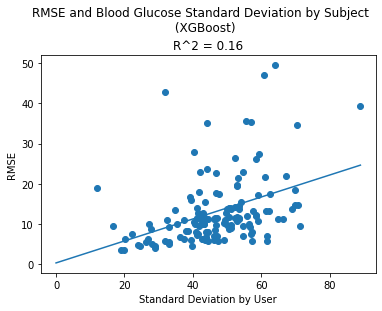

In [45]:
plt.scatter([x[1] for x in test], [x[0] for x in test])
plt.ylabel("RMSE")
plt.xlabel("Standard Deviation by User")
plt.plot(regression_line)
plt.suptitle("RMSE and Blood Glucose Standard Deviation by Subject \n (XGBoost)", y=1.05)
plt.title(f"R^2 = {np.round(r_sq, 2)}")

In [192]:
xgboost_df.head()

,subjectid,entryid,y,y_hat
0,68267781,43948,196.0,195.525818
1,68267781,43947,197.0,200.001999
2,68267781,43942,184.0,195.169403
3,68267781,43940,179.0,184.083710
4,68267781,43938,162.0,174.461395


In [203]:
plot_df = xgboost_df.loc[xgboost_df.subjectid==309157, :]
len(plot_df.reset_index())

11942

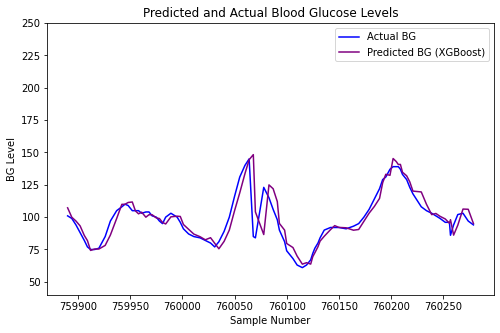

In [200]:
plt.rcParams["figure.figsize"] = (8,5)
plt.plot(plot_df['y'], color='blue', label="Actual BG")
plt.plot(plot_df['y_hat'], color='purple', label="Predicted BG (XGBoost)")
plt.title('Predicted and Actual Blood Glucose Levels')
plt.xlabel('Sample Number')
plt.ylabel('BG Level')
plt.ylim(40, 250)
plt.legend(loc="upper right")
plt.show()


## Predict Forward

### Future X

In [15]:
## Column Prep

# constant_columns = []
# for column in test.columns:
#     if np.isclose(np.std(test[column]), 0):
#         constant_columns.append(column)
# mutable_columns = list(test.columns.difference(constant_columns))

# I'm being exceptionally explicit with the mutable/constant columns. The above code *should*
# compute this list for any data passed into it. However, I worry edge cases could break break it. 

mutable_columns = ['bg_lag_1', 'bg_lag_10', 'bg_lag_11', 'bg_lag_12', 'bg_lag_2', 'bg_lag_3', 'bg_lag_4', 'bg_lag_5',
                   'bg_lag_6', 'bg_lag_7', 'bg_lag_8', 'bg_lag_9', 'carbs', 'datediff_currentbg_lastbg_inseconds',
                   'federal_holiday', 'hour', 'insulin', 'minute', 'ohe_Friday', 'ohe_Monday', 'ohe_Saturday',
                   'ohe_Sunday', 'ohe_Thursday', 'ohe_Tuesday', 'ohe_Wednesday']
constant_columns = ['ohe_221634', 'ohe_309157', 'ohe_897741', 'ohe_1352464', 'ohe_2033176', 'ohe_2199852', 'ohe_4762925',
                    'ohe_5274556', 'ohe_7886752', 'ohe_12689381', 'ohe_13029224', 'ohe_13484299', 'ohe_13783771',
                    'ohe_14092221', 'ohe_15558575', 'ohe_15634563', 'ohe_16975609', 'ohe_17161370', 'ohe_18991425',
                    'ohe_19626656', 'ohe_20216809', 'ohe_20396154', 'ohe_20649783', 'ohe_21946407', 'ohe_22961398',
                    'ohe_23428091', 'ohe_24448124', 'ohe_25692073', 'ohe_26856617', 'ohe_27526291', 'ohe_27819368',
                    'ohe_28176124', 'ohe_28608066', 'ohe_28756888', 'ohe_28768536', 'ohe_32407882', 'ohe_32997134',
                    'ohe_33470634', 'ohe_33831564', 'ohe_33962890', 'ohe_35533061', 'ohe_35719805', 'ohe_37764532',
                    'ohe_37875431', 'ohe_37948668', 'ohe_37998755', 'ohe_38110191', 'ohe_39986716', 'ohe_40237051',
                    'ohe_40634871', 'ohe_40997757', 'ohe_41131654', 'ohe_41663654', 'ohe_42052178', 'ohe_43589707',
                    'ohe_45120081', 'ohe_46253612', 'ohe_47323535', 'ohe_47750728', 'ohe_48509634', 'ohe_48540630',
                    'ohe_49551394', 'ohe_49796612', 'ohe_50311906', 'ohe_51968000', 'ohe_54280576', 'ohe_56568290',
                    'ohe_56958831', 'ohe_57176789', 'ohe_60844515', 'ohe_61179686', 'ohe_62345070', 'ohe_62401782',
                    'ohe_63047517', 'ohe_63725802', 'ohe_64024750', 'ohe_64406000', 'ohe_65143138', 'ohe_66019205',
                    'ohe_66773091', 'ohe_66836068', 'ohe_66937570', 'ohe_67167655', 'ohe_67208817', 'ohe_67359234',
                    'ohe_68026248', 'ohe_68267781', 'ohe_69587086', 'ohe_69739062', 'ohe_69965708', 'ohe_70454270',
                    'ohe_70811987', 'ohe_71236754', 'ohe_71397255', 'ohe_71618088', 'ohe_72492570', 'ohe_73398408',
                    'ohe_73521474', 'ohe_74077367', 'ohe_76817975', 'ohe_77104076', 'ohe_77411181', 'ohe_78420229',
                    'ohe_79526193', 'ohe_80373992', 'ohe_80501215', 'ohe_80625186', 'ohe_80796147', 'ohe_81099003',
                    'ohe_81680176', 'ohe_84109428', 'ohe_84589080', 'ohe_84984656', 'ohe_85199788', 'ohe_85653830',
                    'ohe_86025410', 'ohe_86286077', 'ohe_86323903', 'ohe_87770486', 'ohe_88004055', 'ohe_88252802',
                    'ohe_89032650', 'ohe_89710417', 'ohe_89727223', 'ohe_90398368', 'ohe_91161972', 'ohe_93606058',
                    'ohe_93839818', 'ohe_94200862', 'ohe_95614431', 'ohe_95851255', 'ohe_96254963', 'ohe_96805916',
                    'ohe_97417885', 'ohe_97872409', 'ohe_98340749', 'ohe_98974339', 'ohe_99296581', 'ohe_99712241',
                    'ohe_99848889', 'ohe_99908129', 'observations', 'insulin_datacount', 'carbs_datacount',
                    'normalized_carbs_datapercentile', 'normalized_insulin_datapercentile']

# We don't know future carbs or insulin, so we set this value to zero 
for i in ['carbs', 'insulin']:
    mutable_columns.pop(mutable_columns.index(i))
    constant_columns.append(i)

# Extract Lag columns to modify
lag_columns = []
for i in range(1,13):
    idx = mutable_columns.index(f"bg_lag_{i}")
    lag_columns.append(mutable_columns.pop(idx))
# Expeted input order
ordered_features = bst.feature_names_in_

col_info = {"mutable": mutable_columns,
           "constant": constant_columns,
           "lag": lag_columns, 
           "order": ordered_features}

In [22]:
def create_future_y(group):
    """Take a group of subject data and return the future y dataframe"""
    group_df = group.sort_index()
    group_df = group_df.reset_index()
    original = group_df[["subjectid", "entryid", 'bg']]
    shifts = pd.DataFrame({f"bg_future_{i}": original['bg'].shift(-i) for i in range(1,13)})
    preds = pd.DataFrame({f"bg_pred_{i}": [None for _ in range(len(original))] for i in range(0,13)} )
    merged = original.merge(shifts, left_index=True, right_index=True)
    merged = pd.concat([merged, preds], axis=1)
    return merged

def create_future_mutables(mutable):
    """Take mutable variables,apply a -1 shift, and drop end NA's"""
    # Each row now contains the data of the suceeding row
    shift = mutable.shift(-1)
    # Len(shift) = max(idx)+1, len(shift)-1 = max(idx), len(shift-2) = location of Null row
    shift = shift.loc[0:len(shift)-2, :]
    return shift

def create_future_lags(lag_df, preds):
    """Take lag variables and predictions and apply a shift"""

    # Shift lags
    for j in range(12, 0, -1):
        if j == 1:
            current_column = f"bg_lag_{j}" # lag_bg_1
            lag_df.loc[:, current_column] = pd.to_numeric(preds)
        else:
            current_column = f"bg_lag_{j}"
            prev_column = f"bg_lag_{j-1}"
            lag_df.loc[:, current_column] = lag_df[prev_column].values 
    return lag_df

    # Create new df
    new_df = pd.concat([mutable_df, constant_df, lag_df], axis=1)
    new_df = new_df.reindex(columns=col_info['order'])
    
def compute_future_predictions(group):
    
    # Create Future y dataframe
    future_y_df = create_future_y(group)

    # Create X subset dataframes
    drop_cols = ['subjectid', 'entryid', 'train_set', 'validation_set', 'test_set', 'bg', 'timestamp_clean']
    group = group.sort_index()    
    group = group.reset_index()
    group = group.drop(drop_cols, axis=1)
    mutable_df = group[col_info['mutable']]
    constant_df = group[col_info['constant']]
    lag_df = group[col_info['lag']]
    
    # Generate initial prediction 
    train_X = pd.concat([mutable_df, constant_df, lag_df], axis=1)
    train_X = train_X.reindex(columns = col_info['order'])
    init_preds = bst.predict(train_X)
    if np.isnan(init_preds).any():
        raise Exception() 
    future_y_df['bg_pred_0'] = init_preds

    constant_df.loc[:, 'carbs'] = 0
    constant_df.loc[:, 'insulin'] = 0
    
    # Predict forward
    for i in range(13):
        mutable_df = create_future_mutables(mutable_df)
        if i == 0:
            lag_df = create_future_lags(lag_df, init_preds)
        else:
            lag_df = create_future_lags(lag_df, preds)
        train_X = pd.concat([mutable_df, lag_df, constant_df], axis=1)
        train_X = train_X.dropna()
        train_X = train_X.reindex(columns = col_info['order'])
        preds = bst.predict(train_X)
        
        if np.isnan(init_preds).any():
            raise Exception() 
        
        # As we move forward, we lose data to predict against, so we augment with nulls to get matching indices
        augment_size = len(future_y_df) - len(preds)
        
        preds = np.concatenate( (preds, [None for _ in range(augment_size)]) ) 

        future_y_df[f'bg_pred_{i}'] = preds
    
    loss = {f'future_{i}': None for i in range(1,13)}
    for i in range(1,13):
        pred = future_y_df[f'bg_pred_{i}'].dropna()
        true = future_y_df.loc[:,f'bg_future_{i}'].dropna()
        if len(pred) < len(true):
            true = true.loc[0:len(pred)-1]
#             print(pred.shape, true.shape)
        elif len(pred) > len(true):
            pred = pred.loc[0:len(true)-1]
            
        loss[f'future_{i}'] = true - pred
        mse = mean_squared_error(true, pred)
        
    return future_y_df, loss

In [28]:
# Because we continually split and recombine the data, we receive warnings about setting values on copies
# This line suppresses those warnings
pd.options.mode.chained_assignment = None

In [27]:
results = [] 
losses = []
nas ={}
held_out_subjects = [60844515, 41131654, 40997757, 94200862, 91161972, 28608066,
       76817975, 37875431, 63047517, 72492570, 80796147, 87770486,
       95851255, 70454270]
groups = clean_df.groupby(by='subjectid')
for name, group in groups:
    if name in held_out_subjects:
        pass
    else:
        result_df, loss = compute_future_predictions(group)
        results.append(result_df)
        losses.append(loss)
        nas.update({name: result_df.isna().sum()})

In [37]:
loss_dfs = [pd.DataFrame(loss) for loss in losses]
loss_df = pd.concat(loss_dfs)
loss_df.head()
rmse_dict= {}
for idx, c in enumerate(loss_df.columns):
    n = len(loss_df)
    squared_loss = (loss_df[c] ** 2).sum()
    rmse = np.sqrt(squared_loss/n) 
    rmse_dict.update({idx+1:rmse})
rmse_dict

{1: 17.53553176309449,
 2: 21.473195757351224,
 3: 24.911529784866666,
 4: 28.005459564469042,
 5: 30.774975031048406,
 6: 33.28725092873834,
 7: 35.558881522175966,
 8: 37.62978683749566,
 9: 39.53001614021824,
 10: 41.27404396860191,
 11: 42.88341542109852,
 12: 44.364490044383665}

## LSTM
### Load Model and Data

In [63]:
class Net(nn.Module):
    
    def __init__(self, input_size=30, hidden_size=8, num_lstm_layers=1, dropout=0):
        super().__init__()
        if num_lstm_layers == 1:
            dropout = 0
        self.lstm = nn.LSTM(input_size=input_size,
                            hidden_size=hidden_size,
                            num_layers=num_lstm_layers,
                            dropout=dropout, batch_first=True)
        self.fc1 = nn.Linear(hidden_size, 1)
        
    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        x = self.fc1(lstm_out)
        return x

In [64]:
s3 = s3fs.S3FileSystem()
lstm_folder = "s3://bgpredict/models/lstm"
model_src = f"{lstm_folder}/best_model/best_opt_state_net_state"

In [65]:
with s3.open(model_src, 'rb') as f:
    # This file contains (network_state, optimizer_state) in a tuple. Use [0] to get network-state
    state_dict = torch.load(f, map_location=torch.device('cpu'))[0]

In [66]:
# Best parameters from LSTM/LSTM_prod.ipynb
parameters= {"input_size": 30, "hidden_size": 64, "num_lstm_layers": 2, "dropout": 0.1}
net = Net(**parameters)
net.load_state_dict(state_dict)

<All keys matched successfully>

In [67]:
local_test_X = "./test_X.pt"
remote_test_X = f"{lstm_folder}/tensors/test_X.pt"
if os.path.exists(local_test_X):
    with open(local_test_X, 'rb') as f:
        test_X = torch.load(f)
else:
    with s3.open(remote_test_X, 'rb') as f:
        test_X = torch.load(f)
    with open(local_test_X, 'wb') as f:
        torch.save(test_X, f)

In [68]:
local_test_y = "./test_y.pt"
remote_test_y = f"{lstm_folder}/tensors/test_y.pt"
if os.path.exists(local_test_y):
    with open(local_test_y, 'rb') as f:
        test_y = torch.load(f)
else:
    with s3.open(remote_test_y, 'rb') as f:
        test_y = torch.load(f)
    with open(local_test_y, 'wb') as f:
        torch.save(test_y, f)

In [69]:
local_test_y = "./test_y_augmented.pt"
remote_test_y = f"{lstm_folder}/tensors/test_y_augmented.pt"
if os.path.exists(local_test_y):
    with open(local_test_y, 'rb') as f:
        test_y = torch.load(f)
else:
    with s3.open(remote_test_y, 'rb') as f:
        test_y = torch.load(f)
    with open(local_test_y, 'wb') as f:
        torch.save(test_y, f)

### Metrics

In [71]:
net.eval()
with torch.no_grad():
    out_seq = net(test_X)
    first_dim, second_dim, _ = out_seq.shape
    pred = out_seq.view(first_dim, second_dim)[:, -1]

In [72]:
pred_array = pred.cpu().detach().numpy()
y = test_y[:, 0].detach().numpy()
df = pd.DataFrame({"y_true":y, "y_hat": pred_array})
df = df.loc[df['y_true'] != 0, :]

In [73]:
mse = mean_squared_error(df["y_true"], df["y_hat"])
print(np.sqrt(mse))

8.5973625


### Cross Validation Results

In [31]:
response = s3_conn.s3_client.list_objects_v2(Bucket='bgpredict', Prefix="models/lstm/best_trial_dfs/")
dfs = []
for obj in response['Contents']:
    df = pd.read_csv(f"s3://bgpredict/{obj['Key']}")
    dfs.append(df)

Text(0.5, 1.0, '(N = 100, Minimum Number of Epochs Per Model = 3)')

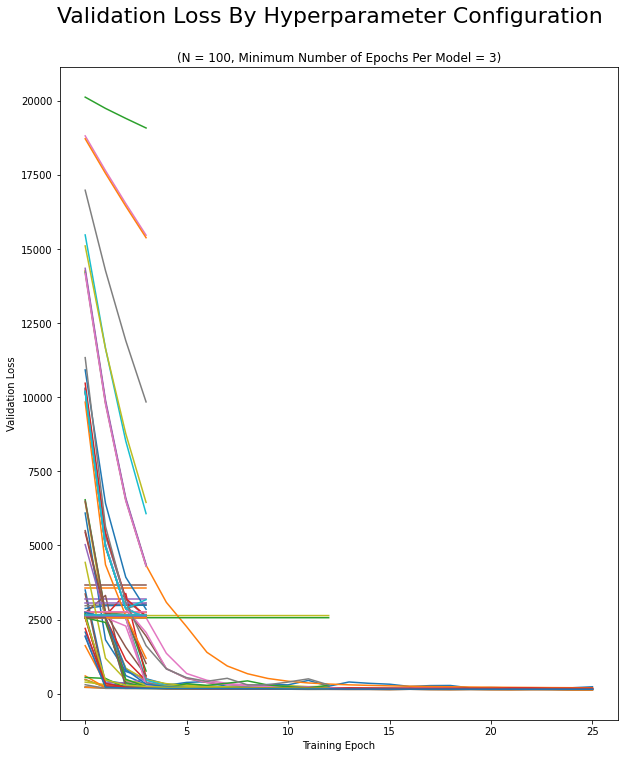

In [50]:
ax = None  # This plots everything on the same plot
for d in dfs:
    ax = d.loc[d['training_iteration'] <= 25, "val_loss"].plot(ax=ax, legend=False, figsize=(10,12))
plt.xlabel("Training Epoch")
plt.ylabel("Validation Loss")
plt.suptitle("Validation Loss By Hyperparameter Configuration", size=22, y=0.95)
plt.title("(N = 100, Minimum Number of Epochs Per Model = 3)")

### Visual Plots

In [80]:
test_y_arr = test_y.detach().numpy()
test_y_df =pd.DataFrame(test_y_arr, columns = ["Actual", 'subjectid', 'entryid'])
test_y_df['Predicted'] = pred_array
test_y_df

,Actual,subjectid,entryid,Predicted
0,196.0,68267784.0,43955.0,192.330185
1,196.0,68267784.0,43948.0,190.238388
2,197.0,68267784.0,43947.0,189.647964
3,184.0,68267784.0,43942.0,182.330475
4,179.0,68267784.0,43940.0,172.109528
...,...,...,...,...
1171251,266.0,56958832.0,29733.0,267.181061
1171252,275.0,56958832.0,29731.0,272.622162
1171253,276.0,56958832.0,29729.0,273.205536
1171254,275.0,56958832.0,29727.0,270.786407


In [86]:
test_groups = test_y_df.groupby('subjectid')
subjects = test_y_df.subjectid.values
subj = np.random.choice(subjects)
subj

24448124.0

In [120]:
for name, df in test_groups:
    if name == subj:
        out =df.reset_index(drop=True)
        break

df.head()

,Actual,subjectid,entryid,Predicted
818082,152.0,24448124.0,220006.0,146.478683
818085,147.0,24448124.0,220004.0,142.154724
818090,144.0,24448124.0,220002.0,137.602951
818098,135.0,24448124.0,220000.0,130.863129
818101,119.0,24448124.0,219999.0,115.723747


In [121]:
clean_df = clean_data(raw_df, drop_cols=['timestamp'])

Null values to be filled by column:
bg_lag_1 6593
bg_lag_2 6449
bg_lag_3 6420
bg_lag_4 6548
bg_lag_5 6614
bg_lag_6 6577
bg_lag_7 6653
bg_lag_8 6720
bg_lag_9 6683
bg_lag_10 6694
bg_lag_11 6746
bg_lag_12 6758
Dropping 0 invalid timestamps


In [135]:
from datetime import date

datetime.date(2019, 2, 4)

In [157]:
merged = df.merge(clean_df.reset_index(), how='left', left_on='entryid', right_on='entryid')
subset = merged.loc[(merged.date.astype(str) == "2019-02-04"), :]

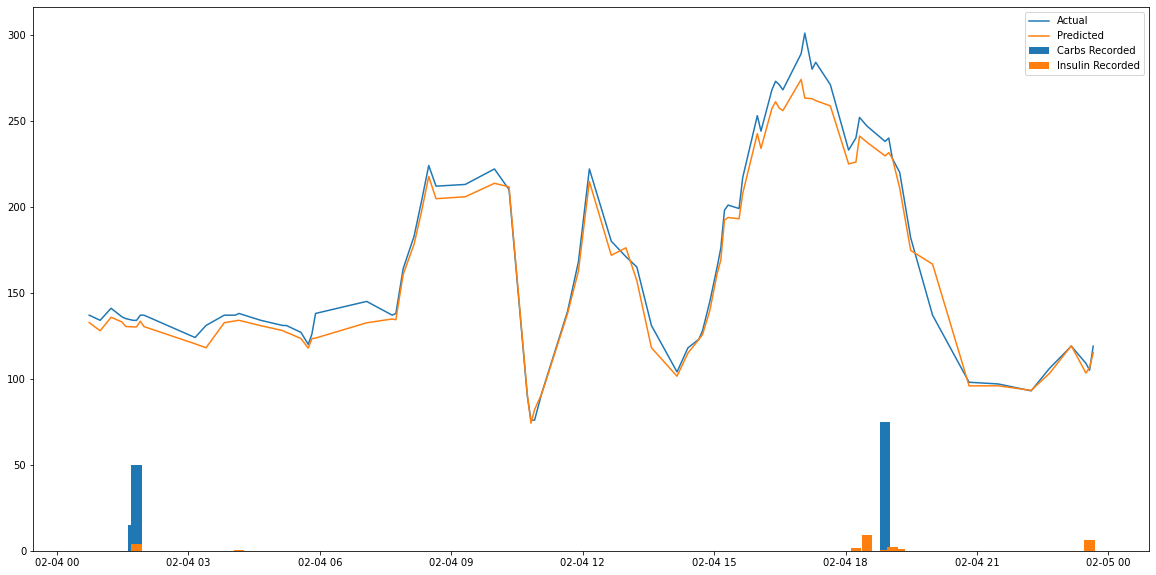

In [177]:
fig, ax = plt.subplots(figsize=(20,10))
ax.plot(subset['timestamp_clean'], subset["Actual"], label="Actual")
ax.plot(subset['timestamp_clean'], subset["Predicted"], label="Predicted")
ax.bar(x=subset['timestamp_clean'], height=subset['carbs'], width=0.01, label="Carbs Recorded")
ax.bar(x=subset['timestamp_clean'], height=subset['insulin'], width=0.01, label="Insulin Recorded")
plt.legend()

In [171]:

fig.show()